# CENG 483 THE 2

**Name: Mert Uludoğan**

**Student ID: 2380996**


## Import Libraries

In [50]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import signal
import time

## Necessary Constants

In [51]:

image_root = "images/"
CHESSBOARD = "images/chessboard.png"
CHESSBOARD_ROTATED = "images/chessboard-rotated.png"
LAB = "images/lab.png"
LAB_ROTATED = "images/lab-rotated.png"
TREE = "images/tree.png"
TREE_ROTATED = "images/tree-rotated.png"

image_paths = [
    CHESSBOARD,
    CHESSBOARD_ROTATED,
    LAB,
    LAB_ROTATED,
    TREE,
    TREE_ROTATED
]

RGB = "viridis"
GRAY = "gray"

window_size = 3
off = window_size//2
window_shape = (window_size, window_size)
shift_size = 1
shift_rang = range(-shift_size, shift_size+1)
offset = shift_size+window_shape[0]//2

non_max_size = 10
k = 0.04
epsilon = 1e-6


## Common Functions

In [52]:
# Returns narray in shape (n, m, 3) // RGB
def readFileRGB(filepath):
    image = Image.open(filepath)
    image_narray = np.asarray(image)
    return image_narray
# Returns narray in shape (n, m, 1) // Grayscale
def readFileGrayscale(filepath):
    image = Image.open(filepath).convert("L")
    image_narray = np.asarray(image)
    return image_narray

def showAll(model_func):
    for i_ in range(3):
        i = i_ * 2
        
        path1 = image_paths[i]
        path2 = image_paths[i+1]
        im1 = readFileRGB(path1)
        im2 = readFileRGB(path2)
        ind1, t1 = model_func(path1)
        ind2, t2 = model_func(path2)
        
        showImagesHorizontal((im1, im2), (ind1, ind2), (path1, path2), (t1, t2))
        
def showImagesHorizontal(images, indices, paths, records, mode=RGB):
    im1, im2 = images
    ind1, ind2 = indices
    p1, p2 = paths
    p1 = p1.split("/")[1]
    p2 = p2.split("/")[1]
    t1, t2 = records

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(im1, cmap=mode)
    if ind1 is not None:
        plt.scatter(ind1[1], ind1[0], color='red', marker='x', label='Points')
    plt.title(f'image_1: {p1} \n time_1: {round(t1, 3)}')
    
    plt.subplot(1, 2, 2)
    plt.imshow(im2, cmap=mode)
    if ind2 is not None:
        plt.scatter(ind2[1], ind2[0], color='red', marker='x', label='Points')
    plt.title(f'image_2: {p2} \n time_2: {round(t2, 3)}')

    plt.show()
        

# Returns narray in shape (n, m, 3) // RGB

def sortedIndices(r):
    t = np.argsort(r.flatten())[::-1]
    sorted_indices = np.unravel_index(t, r.shape)
    return sorted_indices 

def getLimitedIndices(indices, limit):
    return (indices[0][:limit], indices[1][:limit])

## Kernels

In [53]:
uniform_kernel_3 = np.ones((3, 3)) * (1/9)
uniform_kernel_5 = np.ones((5, 5)) * (1/25)
circular_kernel_3 = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
]) * (1/5)
circular_kernel_5 = np.array([
    [0, 0, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [1, 1, 1, 1, 1],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 0, 0]
]) * (1/13)
gaussian_circular_kernel_5 = np.array([
    [0, 0, 1, 0, 0],
    [0, 1, 2, 1, 0],
    [1, 2, 4, 2, 1],
    [0, 1, 2, 1, 0],
    [0, 0, 1, 0, 0]
]) * (1/20)
gaussian_kernel_3 = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
]) * (1/16)
dx_kernel = np.array([[1, 0, -1]])
dy_kernel = dx_kernel.transpose()

## Operational Common Functions

In [54]:
def convolve_2d(in1 ,in2):
    result = signal.convolve2d(in1, in2, mode='same', boundary='symm')
    return result

def NonMaxSuppression(r):
    epsilon = 1e-6
    temp_r = r.copy()
    sel_r_values = np.ones(r.shape, dtype=bool)
    for b in range(non_max_size, temp_r.shape[0]-non_max_size):
        for a in range(non_max_size, temp_r.shape[1]-non_max_size):
            candidates = temp_r[b-non_max_size:b+non_max_size+1, a-non_max_size:a+non_max_size+1]
            max_candidate = np.max(candidates)
            curr_r = candidates[non_max_size, non_max_size]
            if curr_r == max_candidate:
                temp_r[b, a] += epsilon
                sel_r_values[b, a] = False

    r[sel_r_values == True] = 0    
    return r

def calculateE(image, point, shift):
    s_x, s_y = shift
    x, y = point
    window = image[y-off: y+off+1, x-off: x+off+1].astype('int32')
    window_shifted = image[y-off+s_y: y+off+1+s_y, x-off+s_x: x+off+1+s_x].astype('int32')
    sub = np.subtract(window, window_shifted)
    power = sub ** 2
    sum = np.sum(power)
    return sum
        
def Thresholding(r):
    th = 3
    mean_value = np.mean(r)
    std_dev = np.std(r)
    normalized_data = (r - mean_value) / std_dev
    normalized_data[normalized_data < th] = 0
    return normalized_data






## Naive Formula + Uniform Weighting (without Non-Maximum Suppression)



### Helpers

In [55]:
def getRvalues(image):
    r = np.zeros(image.shape)
    for b in range(2, image.shape[0]-2):
        for a in range(2, image.shape[1]-2):
            point = (a, b)
            R = getR(image, point)
            r[b,a] = R
    return r

def getR(image, point):
    e_values = []
    x, y = point
    big_window = image[y-off-1:y+off+2, x-off-1:x+off+2]
    for v in [-1, 0, 1]:
        for u in [-1, 0, 1]:
            if u == 0 and v == 0:
                continue
            shift = (u, v)
            E = calculateE(image, point, shift)
            e_values.append(E)
            
    min_e = min(e_values)
    return min_e


### Formula and Printing

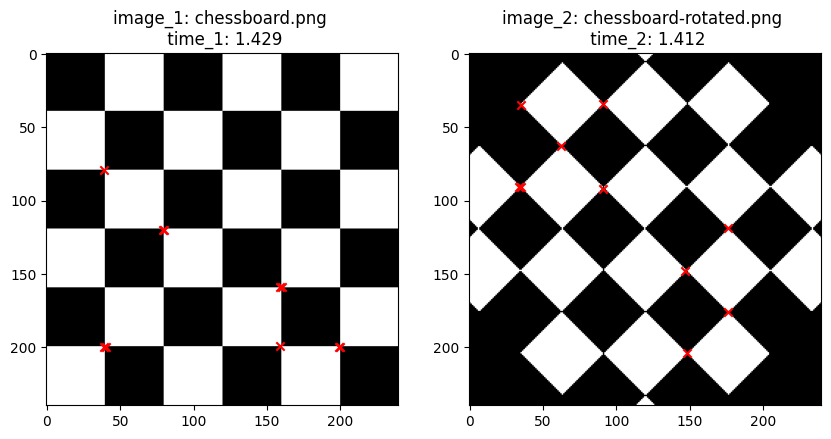

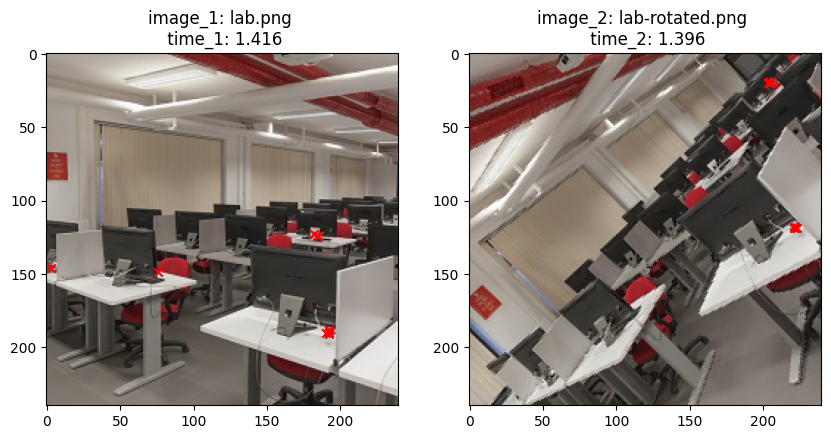

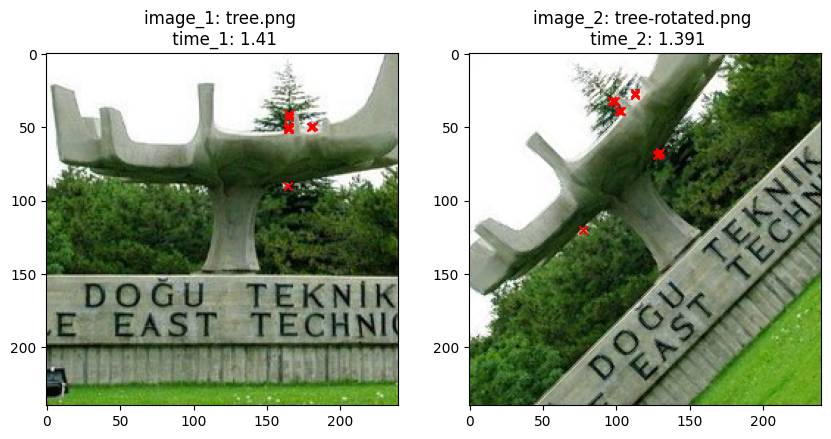

In [56]:

def naive_harris(file):
    image = readFileGrayscale(file)
    tx = time.time()
    r = getRvalues(image)
    r = Thresholding(r)
    ty = time.time()
    indices = sortedIndices(r)
    indices = getLimitedIndices(indices, 10)

    return indices, ty-tx


showAll(naive_harris)        

    

    

### My Comment

This formula considers 8 different directions moving window onto those points and accumulating L2 differences. The minimum values from these shifts is selected as R, corner strength. Ten thresholding is applied.
It is a very discrete method to consider significant shifts to different directions. 

## Naive Formula + Uniform Weighting

### Formula and Printing

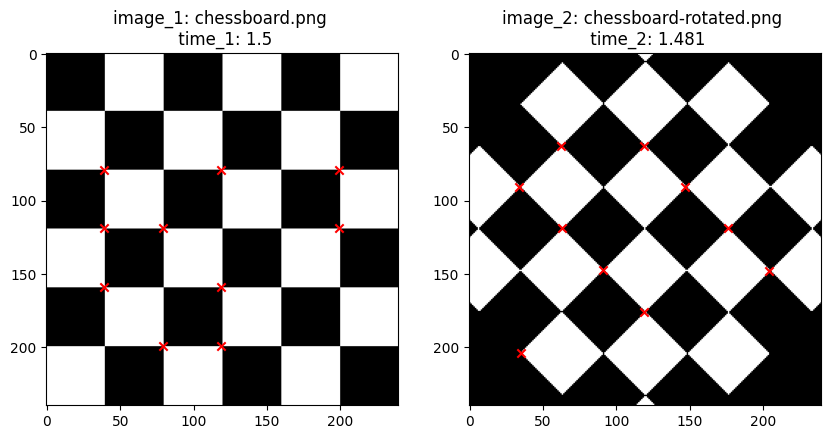

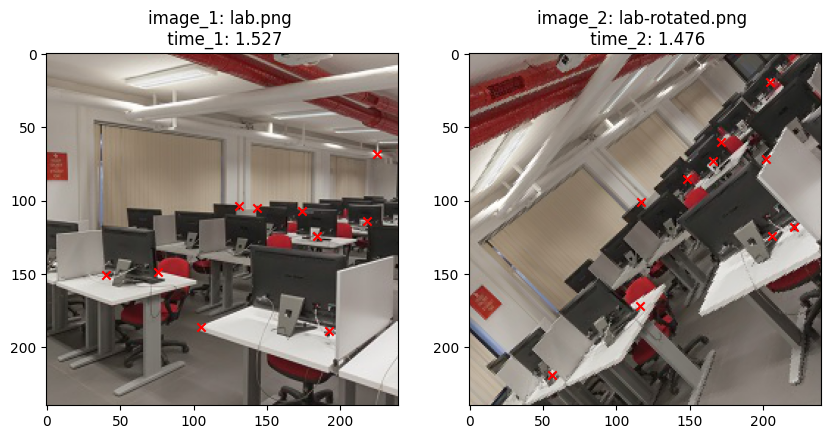

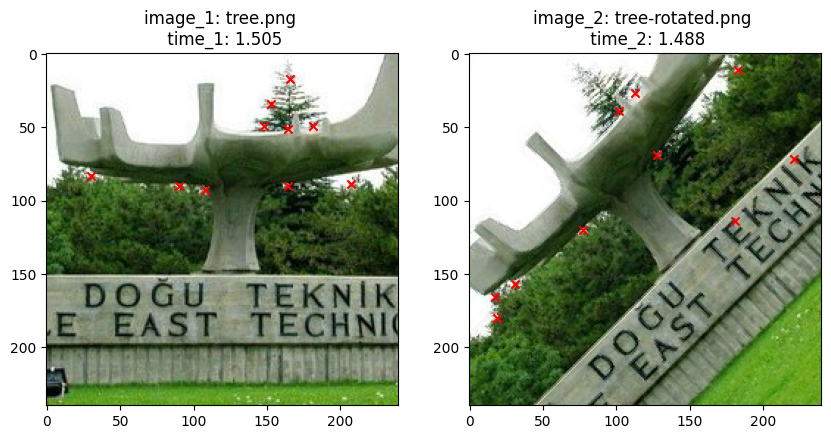

In [57]:

def naive_harris_nonmax(file):
    image = readFileGrayscale(file)
    tx = time.time()
    r = getRvalues(image)
    r = Thresholding(r)
    r = NonMaxSuppression(r)
    ty = time.time()
    indices = sortedIndices(r)
    indices = getLimitedIndices(indices, 10)
    return indices, ty-tx

showAll(naive_harris_nonmax)


### My Comment

Only Non-max suppression is applied to first naive formula. Apparenttly, candidate corner points moved away from each other.

## Taylor's Approximation + Uniform Weighting

### Helpers

In [58]:
def getRvalues_derivative(image_size, h_elements, kernel, R_func):
    r = np.zeros((image_size, image_size))
    Ix2, Ixy, Iy2 = h_elements

    h = np.zeros((image_size, image_size, 2, 2))
    h[:,:,0,0] = convolve_2d(Ix2, kernel) 
    h[:,:,0,1] = convolve_2d(Ixy, kernel)
    h[:,:,1,0] = convolve_2d(Ixy, kernel)
    h[:,:,1,1] = convolve_2d(Iy2, kernel)
    
    for b in range(off, h.shape[0]-off):
        for a in range(off, h.shape[0]-off):
            H = h[b, a]
            R = R_func(H)
            r[b, a] = R
    return r
def getR_taylor(H):
    eigenvalues, eigenvectors = np.linalg.eig(H)
    e1, e2 = eigenvalues
    R = (e1 * e2) - k*(e1 + e2)**2
    return R



### Formula and Printing

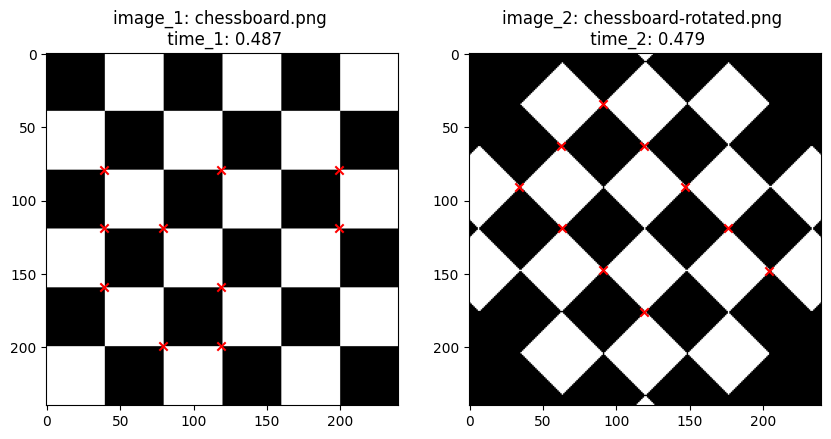

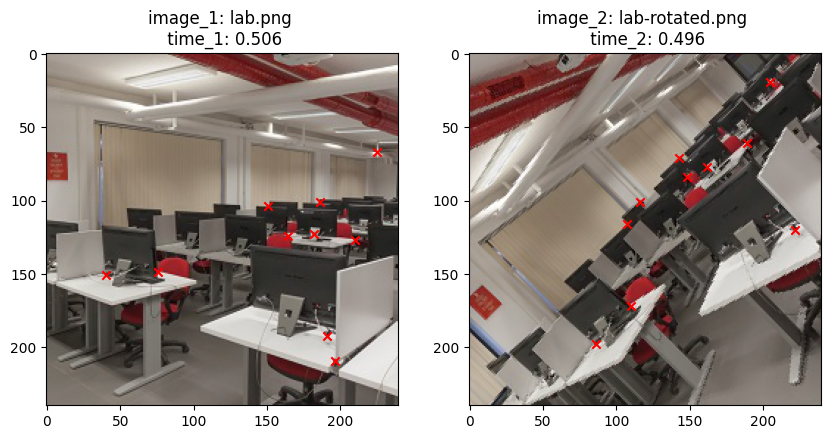

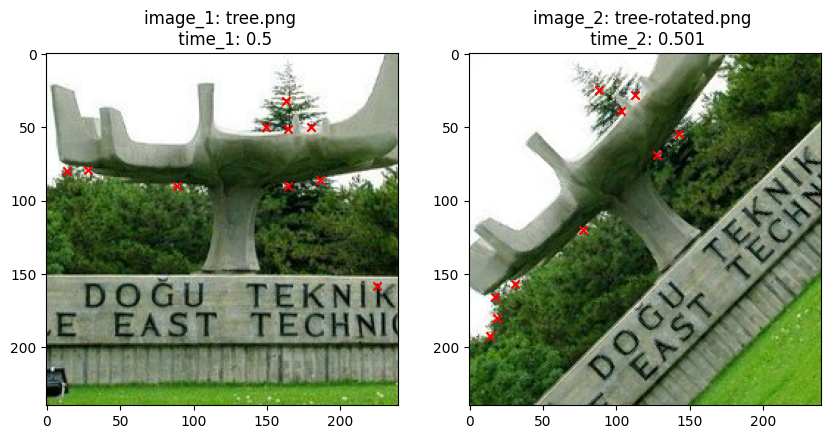

In [59]:
# r: image shaped, corner stength np.array  
def taylor_approx(file):
    image = readFileGrayscale(file)
    
    tx = time.time()
    
    
    Ix = convolve_2d(image, dx_kernel)
    Iy = convolve_2d(image, dy_kernel)
    
    Ix2 = Ix ** 2
    Iy2 = Iy ** 2
    Ixy = Ix * Iy
    
    r = getRvalues_derivative(image.shape[0], (Ix2, Ixy, Iy2), uniform_kernel_3, getR_taylor)
    r = Thresholding(r)
    r = NonMaxSuppression(r)
    
    ty = time.time()
    
    indices = sortedIndices(r)
    indices = getLimitedIndices(indices, 10)
    return indices, ty-tx
 
showAll(taylor_approx)


### My Comment

In this formula, derivates of the image are calculated as Ix and Iy. then Ix^2 , Iy^2 amd Ix*Iy are calculated to construct "Harris matrix". Then for each point and its window, R is calculated using eigenvalues of the current matrix. 

## Fast Implementation Template

### Helpers

In [60]:
def getR_fast(H):        
    det = np.linalg.det(H)
    trace = np.trace(H)
    R = det - k*(trace)**2
    return R

### Formula

In [61]:

def fast_harris(file, kernel, rgb_split=False):
    image = readFileGrayscale(file)
    tx = time.time()
    
    Ix = convolve_2d(image, dx_kernel)
    Iy = convolve_2d(image, dy_kernel)
    
    Ix2 = Ix ** 2
    Iy2 = Iy ** 2
    Ixy = Ix * Iy
    
    r = getRvalues_derivative(image.shape[0], (Ix2, Ixy, Iy2), kernel, getR_fast)
    r = Thresholding(r)
    r = NonMaxSuppression(r)
    
    ty = time.time()
    
    indices = sortedIndices(r)
    indices = getLimitedIndices(indices, 10)
    return indices, ty-tx

def fast_harris_rgb(file, kernel):
    image = readFileRGB(file)
    
    tx = time.time()
    
    # image red (240, 240, 1)
    ir = image[:,:,0] 
    ir_x = convolve_2d(ir, dx_kernel)
    ir_y = convolve_2d(ir, dy_kernel)
    ir_x2 = ir_x ** 2
    ir_y2 = ir_y ** 2
    ir_xy = ir_x * ir_y
    ir_r = getRvalues_derivative(image.shape[0], (ir_x2, ir_xy, ir_y2), kernel, getR_fast)

    # image green (240, 240, 1)
    ig = image[:,:,1]
    ig_x = convolve_2d(ig, dx_kernel)
    ig_y = convolve_2d(ig, dy_kernel)
    ig_x2 = ig_x ** 2
    ig_y2 = ig_y ** 2
    ig_xy = ig_x * ig_y
    ig_r = getRvalues_derivative(image.shape[0], (ig_x2, ig_xy, ig_y2), kernel, getR_fast)

    # image blue (240, 240, 1)
    ib = image[:,:,2]
    
    ib_x = convolve_2d(ib, dx_kernel)
    ib_y = convolve_2d(ib, dy_kernel)
    ib_x2 = ib_x ** 2
    ib_y2 = ib_y ** 2
    ib_xy = ib_x * ib_y
    ib_r = getRvalues_derivative(image.shape[0], (ib_x2, ib_xy, ib_y2), kernel, getR_fast)
    
    # summation of splitted color channels
    r = ir_r + ig_r + ib_r
    r = Thresholding(r)
    r = NonMaxSuppression(r)
    ty = time.time()
    
    indices = sortedIndices(r)
    indices = getLimitedIndices(indices, 10)
    return indices, ty-tx


Different than Taylor Approximation, corner strength is found by det(ImageShaped_HarrisMatrix) and trace(ImageShaped_HarrisMatrix).

## Fast Implementation + Uniform Weighting

### Printing

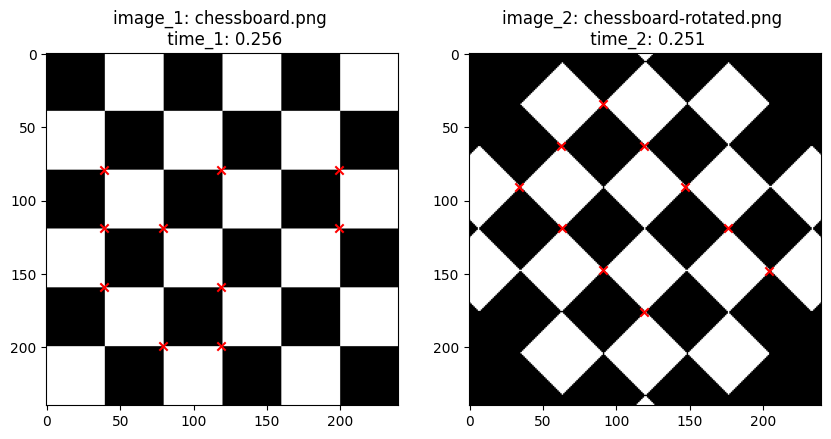

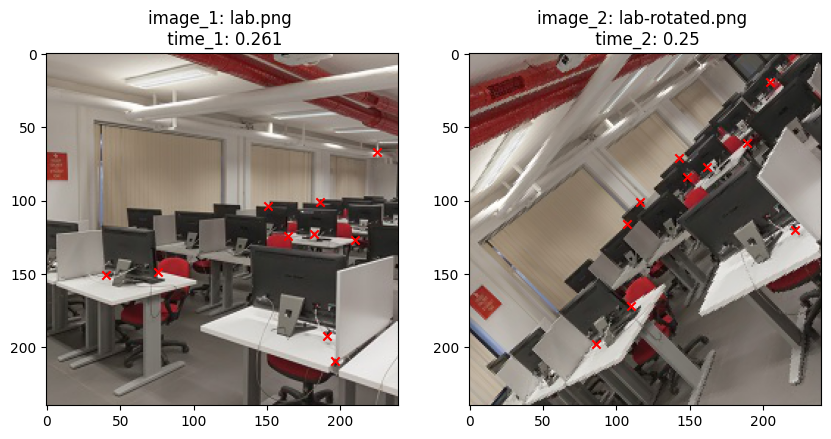

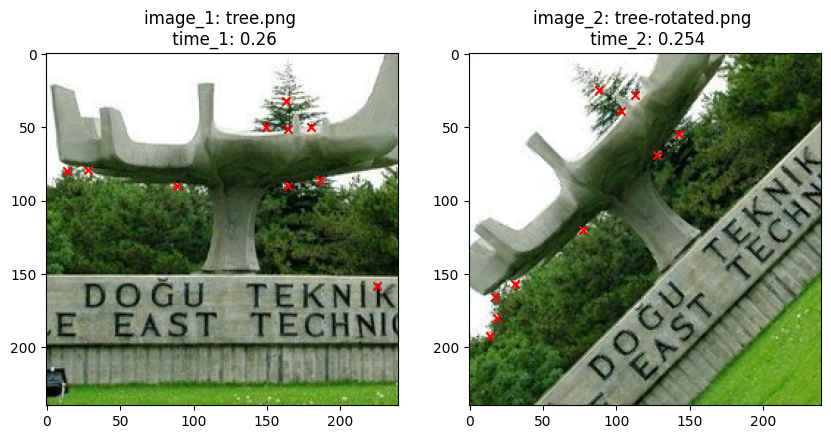

In [62]:
# Write your code

showAll(lambda file: fast_harris(file, uniform_kernel_3))


### My Comments

Unform distribution is used on window. It is linearly sensitive to neighbour changes so it is a naive approach.

## Fast Implementation + Circular Weighting

### Printing

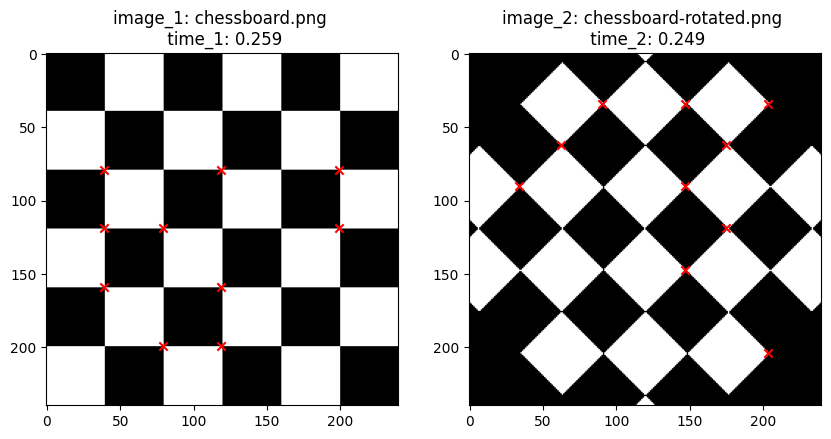

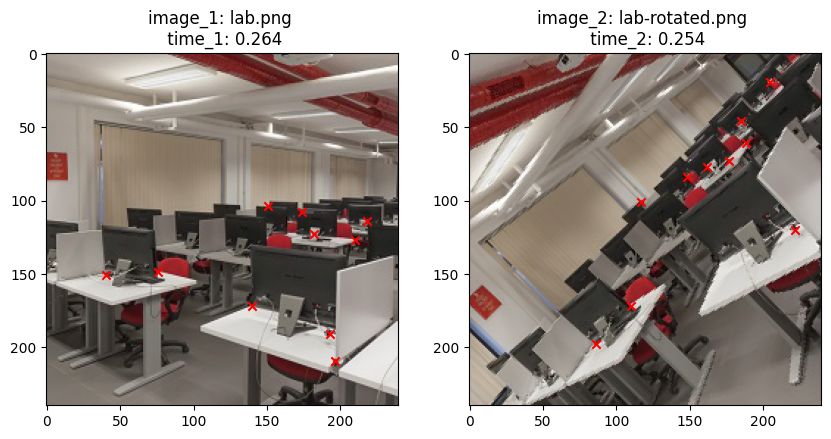

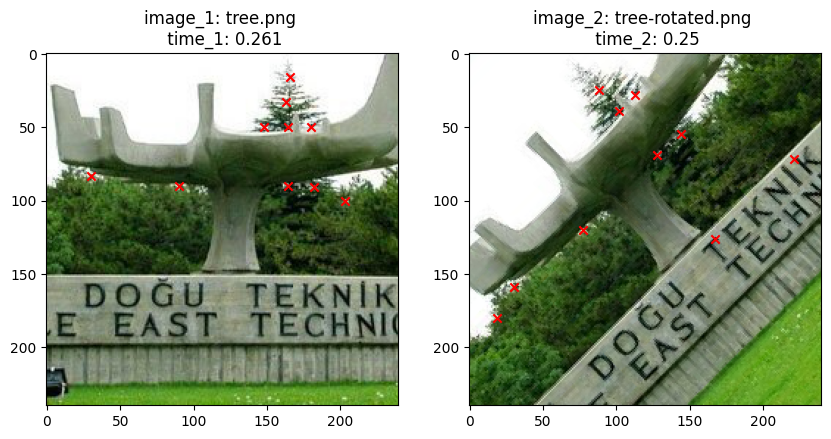

In [63]:
# Write your code here

showAll(lambda file: fast_harris(file, circular_kernel_3))


### My Comments

Circular weighting is used, It is again linear weighting but on more circular shape area. It may balance the effect of rotation cause it always aim to reach certain distant neighbour points.

## Fast Implementation + Gaussian Weighting

### Printing

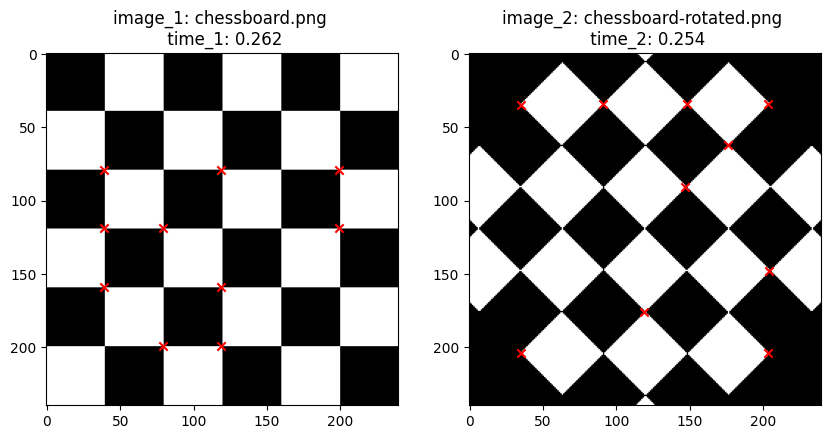

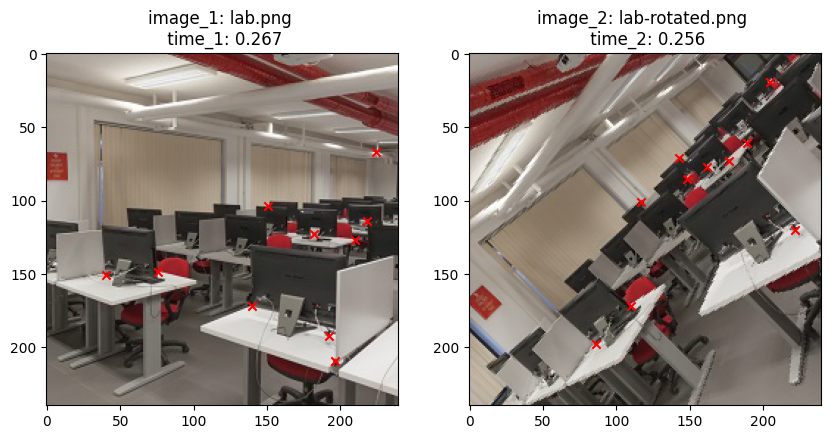

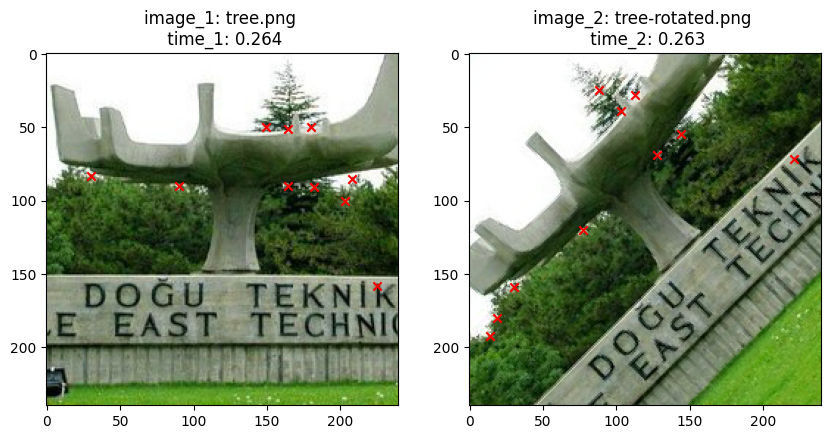

In [64]:
            
# Write your code
            
showAll(lambda file: fast_harris(file, gaussian_kernel_3))


### My Comments

Gaussian weighting is used. It is more multinominal approach as weighing the neighbours inproportionally with their distance to center point of window. So we more rely on center point's values on Harris matrix.

## Fast Implementation + Gaussian Weighting + RGB Split

### Printing

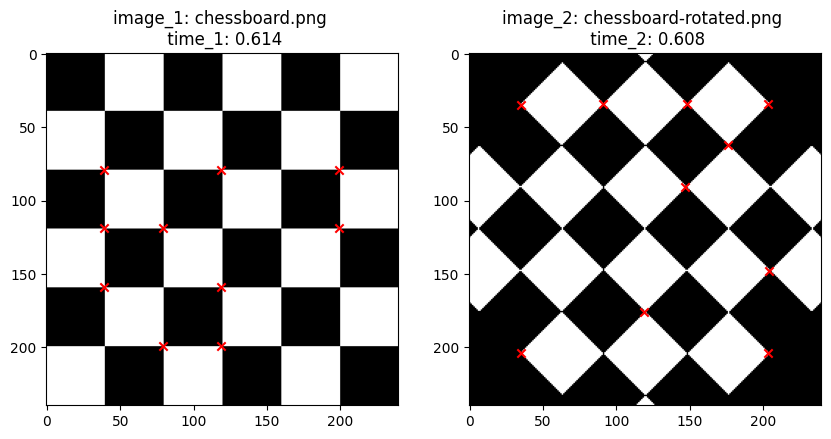

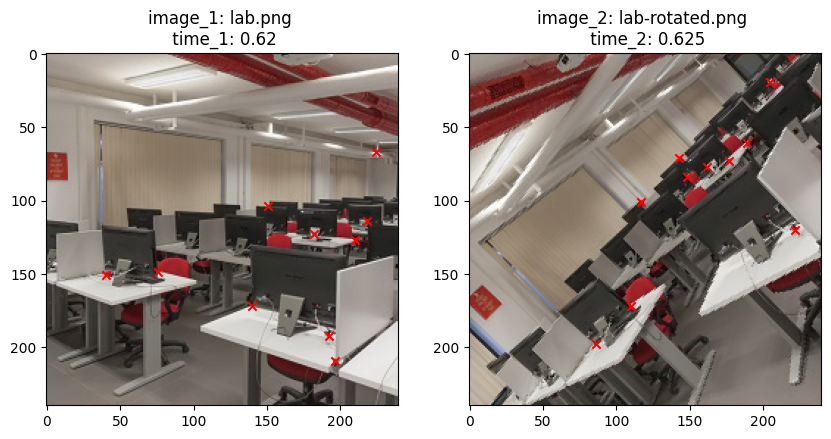

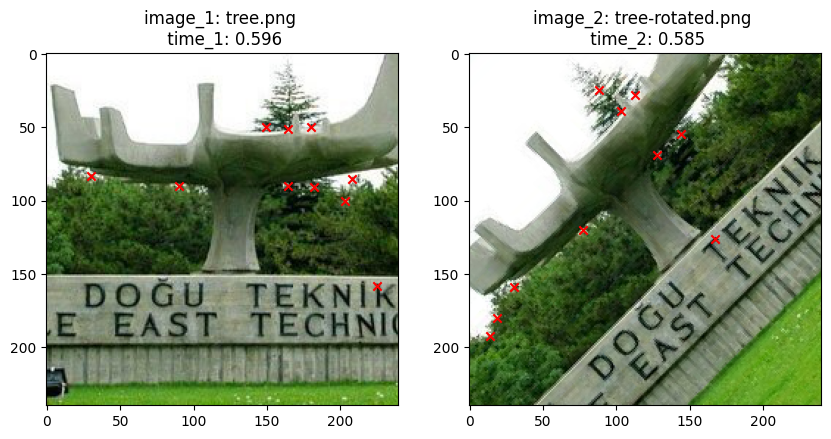

In [65]:


showAll(lambda file: fast_harris_rgb(file, gaussian_kernel_3))


### My Comments

This approach considers the different dimensions in linear approach. All functions are applied independantly, then R values are accumulated. So it calculates corner strength's of red, green, blue dimensions as weighing them equally. It maybe can be extended to different weighing approaches like:
 
.( weight_1 * R_independant_color_dimension_1 ) + ( weigth_2 * R_...) + ...

It is again successful with its relevants on grayscale examples.

# Conclusion


- I think best approach is Fast Implementation with Circular Weighting. It is more natural approach in this case as I see. Gaussian is also very effective but I rather to search on radial dimension (circular, cubic, etc). 
-In Fast - Circular method, Default vs Rotated accuracy is good, they have generally common and rarely distinct corner candidates. In average, it seems successful.
- Some strong color changes are not considered in top-10, so I'm confused. Noising may cause that or bigger windows may help.
- I tried other kernels. You can see the kernels in "Kernels" section. Even I correct some false negatives, new false positives are appeared also. I can not be sure about it is about the algorithm's limition, noising, thresholding, etc.
- Parameter tuning can be very effective on this little error margin. Parameters on methods are set to default as 3x3 kernel, k=0.4, etc. So I observed different combination parameters. It is hard find all patterns but I set k to as low as possible, so maybe the very low resolution may push some parameters to limit.
- Some mixed combination kernels applied on methods like gaussian circular. Observed distinct points but not dramatic results.
- Non-Max suppression is applied on 10x10 area.  I also tried other configurations. When I consider the image sizes, I think this is a valid size.

- For the cases of equal values' comparisons in Non-Max, I added epsilon for the first countered value, to correct the next window functions on this case.

- While Naive approaches are slow on processes, taylor and fast impl are  x4 faster.
- In Naive Approach, selecting minimum corner strength value on 8 different location is very uncommon approach actually. I also tried 4 different, orthogonal. It is more successful. I think choosing more dimension, more sample, require quality image. Using image-oriented kernels on shifted window may be solution. Briefly, considering shifted windows upon image features, like resolution.
 